# **Implied Volatility Surface Modelling**

In [60]:
%load_ext autoreload
%autoreload 2

import itertools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from abc import ABC, abstractmethod
from mpl_toolkits.mplot3d import Axes3D
from typing import Tuple
from scipy.interpolate import griddata, interp1d, PchipInterpolator
from scipy.optimize import differential_evolution, minimize

import utility.plot_helpers as ph

np.random.seed(42)

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
file = "data/intermediate/full_spx_options_2023.parquet"

cols = [
    "strike", "underlying_last", 
    "dte", "expiry",
    "c_delta", "p_delta", 
    "c_iv", "p_iv",
    "c_last", "p_last",
    "c_volume", "p_volume",
    "c_bid", "c_ask",
    "p_bid", "p_ask"
]

options = pd.read_parquet(file, columns=cols)
options["T"] = options["dte"] / 252 # Time to expity in years
options["k"] = np.log(
    options["strike"] / options["underlying_last"] # log moneyness
 )
options

,strike,underlying_last,dte,expiry,c_delta,p_delta,c_iv,p_iv,c_last,p_last,c_volume,p_volume,c_bid,c_ask,p_bid,p_ask,T,k
date,,,,,,,,,,,,,,,,,,
2023-01-04,1000.0,3853.39,0.0,2023-01-04,1.00000,0.00000,NaN,8.17536,3041.37,0.03,1.0,7.0,2846.8,2848.3,0.0,0.05,0.000000,-1.348953
2023-01-04,1200.0,3853.39,0.0,2023-01-04,1.00000,0.00000,NaN,7.06724,0.00,0.00,1.0,0.0,2646.8,2648.3,0.0,0.05,0.000000,-1.166632
2023-01-04,1400.0,3853.39,0.0,2023-01-04,1.00000,-0.00025,NaN,6.13893,0.00,0.00,0.0,0.0,2427.6,2471.0,0.0,0.05,0.000000,-1.012481
2023-01-04,1600.0,3853.39,0.0,2023-01-04,1.00000,0.00000,NaN,5.33125,2417.29,0.00,1.0,0.0,2246.8,2248.3,0.0,0.05,0.000000,-0.878950
2023-01-04,1800.0,3853.39,0.0,2023-01-04,1.00000,0.00000,NaN,4.61644,0.00,0.00,0.0,0.0,2046.8,2048.3,0.0,0.05,0.000000,-0.761167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-29,7200.0,4772.17,2184.0,2029-12-21,0.29633,-1.00000,0.17401,NaN,0.00,0.00,0.0,0.0,286.8,366.8,1550.9,1630.90,8.666667,0.411280
2023-12-29,7400.0,4772.17,2184.0,2029-12-21,0.27129,-1.00000,0.17063,NaN,0.00,0.00,0.0,0.0,245.4,325.4,1669.0,1749.00,8.666667,0.438679
2023-12-29,7600.0,4772.17,2184.0,2029-12-21,0.24709,-1.00000,0.16688,NaN,0.00,0.00,0.0,0.0,208.7,288.7,1791.8,1871.80,8.666667,0.465347


In [3]:
# Calibration day
date = '2023-12-20'
options_red = options[options.index == date]

In [86]:
class IVSurfaceModel(ABC):
    """Abstract base for any IV‐surface model."""
    def __init__(self):
        # once you fit, we’ll remember the spot price
        self._spot: float = None
        self._last_market = None
        
    @staticmethod
    def prepare_iv_surface(options: pd.DataFrame):
        df = options.copy()

        # choose OTM vol
        df['iv_smile'] = np.where(
            df['strike'] < df['underlying_last'], 
            df['p_iv'],
            np.where(
                df['strike'] > df['underlying_last'], 
                df['c_iv'], 
                0.5*(df['c_iv'] + df['p_iv'])
            )
        )
        df['k'] = np.log(df['strike'] / df['underlying_last'])
        df['w'] = df['iv_smile']**2 * df['T'] # total variance

        return df
    
    @staticmethod
    def _moneyness_band(T):
        """Return (m_lo, m_hi) given T in years."""
        days = T * 252
        if days < 7:
            return 0.90, 1.05
        elif days < 30:
            return 0.85, 1.15
        elif days < 180:
            return 0.80, 1.20
        else:
            return 0.70, 1.30

    @abstractmethod
    def fit(self, market_data: pd.DataFrame) -> None:
        """Calibrate to raw market quotes (DataFrame of k, T, σ_mkt)."""
        pass

    @abstractmethod
    def _implied_total_variance(self, k: np.ndarray, T: np.ndarray) -> np.ndarray:
        """Return total variance w(k,T)."""
        pass
    
    def implied_vol(self, K: np.ndarray, T: np.ndarray) -> np.ndarray:
        if self._last_market is None:
            raise RuntimeError("You must .fit(...) first to")

        K_arr = np.atleast_1d(K).astype(float)
        T_arr = np.atleast_1d(T).astype(float)
        spot = self._last_market["underlying_last"].iloc[0]
        k_arr = np.log(K_arr / spot)

        w = self._implied_total_variance(k_arr, T_arr)

        if w.ndim == 2 and T_arr.ndim == 1:
            T_arr = T_arr[:, None]

        iv = np.sqrt(w / T_arr)
        return iv.item() if iv.size == 1 else iv
    
    def check_arbitrage(self,
                        n_k:int=201,           # grid density in k
                        n_T:int=120,           # extra grid steps in T
                        k_pad:float=0.05,      # extend k-range slightly
                        tol:float=1e-10        # numerical tolerance
                    ):
        """
        Static-arbitrage diagnostics.
        Returns (ok, report_df) where ok=True if no violation.
        """
        if self._last_market is None:
            raise RuntimeError("You must .fit(...) first to")
        
        # ---------- build k,T grid covering fitted region -----------
        # maturities we actually calibrated
        df = self._last_market
        k = df["k"]

        T_slice = np.array(sorted(df["T"].unique()))
        T_min, T_max = T_slice.min(), T_slice.max()
        T_grid = np.concatenate([T_slice,
                                np.linspace(T_min, T_max, n_T)])
        T_grid = np.unique(np.round(T_grid, 6))      # drop duplicates

        k_min, k_max = k.min() - k_pad, k.max() + k_pad
        k_grid = np.linspace(k_min, k_max, n_k)

        W = self._implied_total_variance(k_grid, T_grid)   # (nT, nK)

        # ---------- butterfly test: ∂²w/∂k² >= 0 --------------
        dk = k_grid[1]-k_grid[0]
        dw2_dk2 = (W[:,2:] - 2*W[:,1:-1] + W[:,:-2]) / dk**2
        butterfly_ok = (dw2_dk2 >= -tol)

        # ---------- calendar test: ∂w/∂T >= 0 -----------------
        dT = np.diff(T_grid)
        dw_dT = (np.diff(W, axis=0).T / dT).T    # broadcast over k
        calendar_ok = (dw_dT >= -tol)

        # ---------- summary report -----------------------------
        bad_bfly = np.where(~butterfly_ok)
        bad_cal  = np.where(~calendar_ok)

        rows = []
        for r,c in zip(*bad_bfly):
            rows.append({"type":"butterfly",
                        "T":T_grid[r],
                        "k":k_grid[c+1],
                        "value":dw2_dk2[r,c]})
        for r,c in zip(*bad_cal):
            rows.append({"type":"calendar",
                        "T":(T_grid[r]+T_grid[r+1])/2,
                        "k":k_grid[c],
                        "value":dw_dT[r,c]})

        report = pd.DataFrame(rows) if rows else pd.DataFrame(
                columns=["type","T","k","value"])

        return report
    
    def plot_smiles(
            self,
            target_days=[1,5,10,15,20,25,30,40,50,60,126,252],
            #moneyness_band: Tuple[float, float] = [0.8, 1.2],
            total_var=False,
    ):
        """
        3×4 grid of IV(k) using the maturities closest to `target_days`.
        """
        if self._last_market is None:
            raise RuntimeError("You must .fit(...) first to")
        df = self._last_market.copy()
        df["days"] = (df["T"] * 252).round().astype(int)

        def closest_distinct(avail_days, targets):
            avail = np.asarray(sorted(avail_days))
            chosen = []
            for t in targets:
                if avail.size == 0:
                    chosen.append(None)            # placeholder -> blank subplot
                    continue
                idx = np.abs(avail - t).argmin()
                chosen.append(int(avail[idx]))
                avail = np.delete(avail, idx)      # no duplicates
            return chosen

        # choose the nearest available maturity for each target
        chosen_days = closest_distinct(df["days"].unique(), target_days)

        # build 3×4 grid
        fig, axes = plt.subplots(3, 4, figsize=(16, 9))
        axes = axes.flatten()

        for ax, D in zip(axes, chosen_days):
            if D is None:            # no maturity left—blank this cell
                ax.axis("off")
                continue

            T_i = D / 252.0
            slice_df  = df[np.isclose(df["T"], T_i)]
            
            m_lo, m_hi = self._moneyness_band(T_i)
            k_lo, k_hi = np.log(m_lo), np.log(m_hi)
            slice_df = slice_df[
                (slice_df["k"] >= k_lo) & 
                (slice_df["k"] <= k_hi)
            ].copy()
            
            k = slice_df["k"].values

            if total_var:
                model = slice_df["w"].values
                market = self._implied_total_variance(k, T_i).ravel()
            else:
                model = slice_df["iv_smile"].values
                market = self.implied_vol(slice_df["strike"], T_i).ravel()
            label = "TIVar" if total_var else "IV"

            ax.scatter(k, model, s=18, alpha=0.8, color="blue", label=f"Market {label}")
            ax.plot(k, market, color="red", label=f"Model {label}")
            ax.axvline(0, lw=.6, c="black", linestyle="--")

            ax.set_title(f"DTE = {int(D)}", fontsize=12)
            ax.set_xlabel("Log-Forward Moneyness (k)")
            title = "Total Implied Variance" if total_var else "Implied Volatility (IV)"
            ax.set_ylabel(f"{title}")
            ax.legend(loc="upper right")

        title = "SVI vs Market "
        title += "Total Implied Variances" if total_var else "Implied Volatilities"
        fig.suptitle(title, fontsize=18, y=1.02)
        fig.tight_layout()
        plt.show()

    def plot_surface(
        self,
        moneyness_band=(0.8, 1.2),
        dte_band=(1, 60),
        n_strikes=50,
        n_dtes=50,
        method_name=None,
        ax=None,
    ):
        if self._last_market is None:
            raise RuntimeError("You must .fit(...) first to")
        """Plot the full IV surface over strike and maturity."""
        df = self._last_market.copy()
        spot = df["underlying_last"].iloc[0]

        # filter maturities
        df['DTE'] = (df['T'] * 252).round().astype(int)
        valid = np.unique(df['DTE'])
        d_min, d_max = dte_band
        dtes = valid[(valid >= d_min) & (valid <= d_max)]
        if len(dtes)==0:
            raise ValueError("No expiries in dte_band")
        
        # build T grid in years
        T_grid = np.linspace(d_min/252, d_max/252, n_dtes)

        # determine strike band
        strikes_obs = df[df['DTE'].isin(dtes)]['strike']
        K_min = max(strikes_obs.min(), spot*moneyness_band[0])
        K_max = min(strikes_obs.max(), spot*moneyness_band[1])
        K_grid = np.linspace(K_min, K_max, n_strikes)

        # mesh and evaluate
        IV_mesh = self.implied_vol(K_grid, T_grid)
        K_mesh, T_mesh = np.meshgrid(K_grid, T_grid)

        if ax is None:
            fig = plt.figure(figsize=(12, 8))
            ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(
            K_mesh, T_mesh*252, IV_mesh,
            cmap='viridis', alpha=0.8, antialiased=True

        )

        for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
            ginfo = axis._axinfo["grid"]
            ginfo['color']     = (0.1, 0.1, 0.1, 0.2)
            ginfo['linewidth'] = 0.5
        
        ax.set_facecolor('white')
        ax.zaxis.labelpad = 10 
        ax.tick_params(axis='z', pad=6)
        ax.set_xlabel('Strike', fontsize=12)
        ax.set_ylabel('DTE (days)', fontsize=12)
        ax.set_zlabel('Implied Vol', fontsize=12)
        title = 'Implied Volatility Surface'
        title += f": {method_name}" if method_name else ""
        ax.set_title(title, fontsize=16, y=1.03)
        
        cbar = plt.colorbar(surf, ax=ax, pad=0.1, shrink=0.5, aspect=10)
        cbar.set_label('IV', rotation=0, labelpad=15)

        return ax

## **Non-parametric: Spline interpolation**


In [87]:
class InterpSurface(IVSurfaceModel):
    """
    Non-parametric interpolator for total implied variance w(k, T).
    - If only one unique T is provided, falls back to 1D interpolation in k.
    - Otherwise uses 2D griddata interpolation.
    """
    def __init__(self, method: str = 'cubic'):
        self.method = method
        self._1d_spline = None
        self._2d_data = None

    def fit(self, market_data: pd.DataFrame) -> None:
        """Fit the interpolator."""
        self._spot = market_data["underlying_last"].iloc[0]

        df = self.prepare_iv_surface(market_data)
        ks = df['k'].to_numpy()
        Ts = df['T'].to_numpy()
        ws = df['w'].to_numpy() # Total variance
        self._last_market = df.copy()

        unique_T = np.unique(Ts)
        if len(unique_T) == 1:
            # Single-maturity case: build a 1D spline in k
            order = np.argsort(ks)
            self._1d_spline = interp1d(
                ks[order], ws[order],
                kind=self.method,
                fill_value="extrapolate",
            )
        else:
            # Full-surface case: store the raw arrays for 2D interpolation
            self._2d_data = (ks, Ts, ws)

    def _implied_total_variance(self, k: np.ndarray, T: np.ndarray) -> np.ndarray:
        """Query the interpolated total variance w(k, T)."""
        if self._1d_spline is not None:
            # Only one maturity in fit → ignore T
            return self._1d_spline(k)
        
        # 2D interpolation via griddata
        ks, Ts, ws = self._2d_data
        pts = np.column_stack((ks, Ts))

        # 2) build a mesh of *query* k‐and‐T pairs
        Kq, Tq = np.meshgrid(k, T, indexing="xy")        # (len(T), len(k))
        qry = np.column_stack((Kq.ravel(), Tq.ravel())) # (len(T)*len(k), 2)

        # 3) interpolate and reshape back into (len(T), len(k))
        Wq = griddata(pts, ws, qry, method=self.method)
        return Wq.reshape(len(T), len(k))

In [88]:
interp_iv = InterpSurface(method='linear')
interp_iv.fit(options_red)

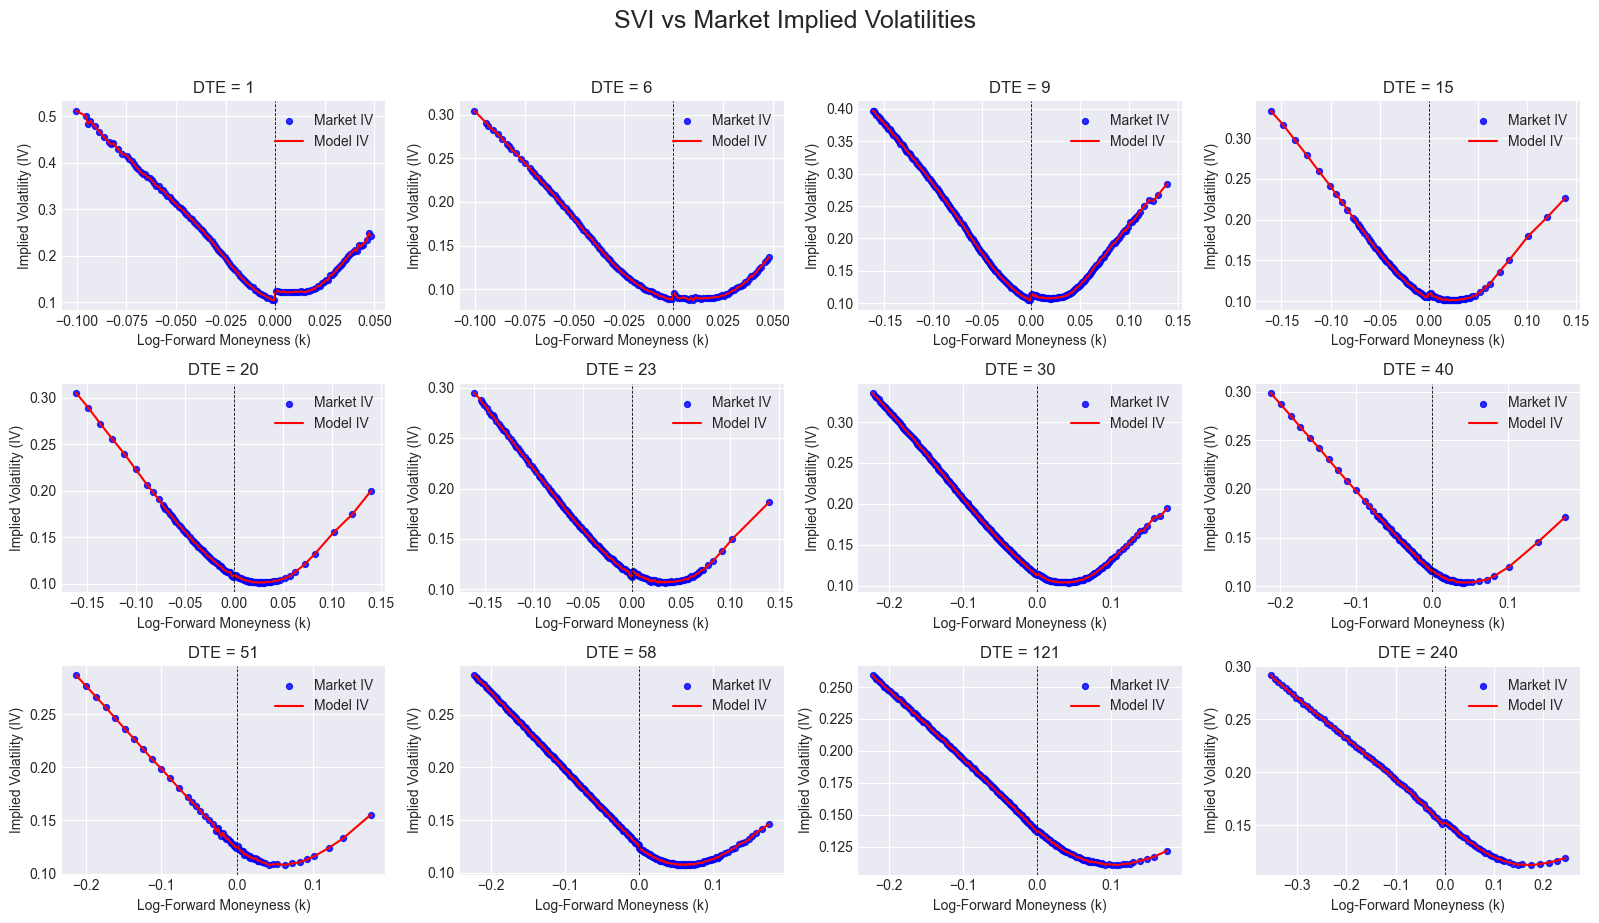

In [7]:
interp_iv.plot_smiles()

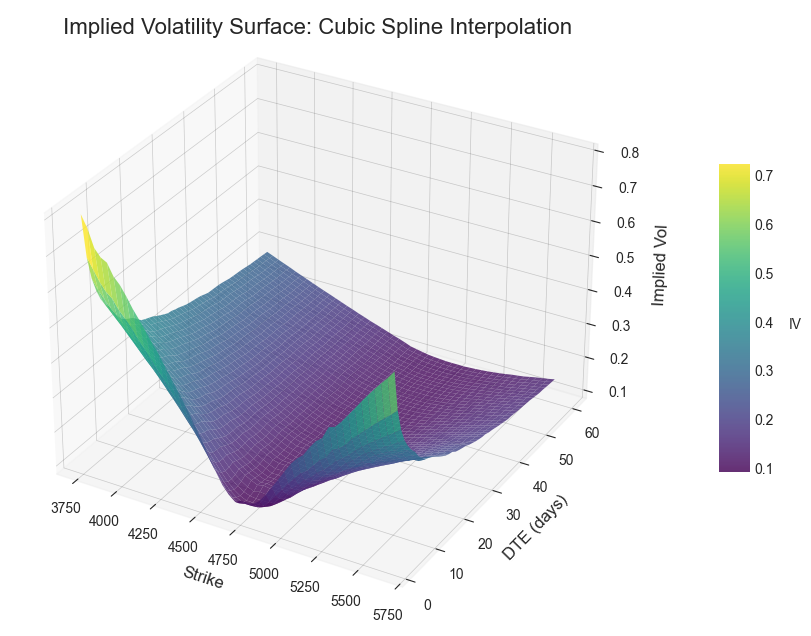

In [8]:
interp_iv.plot_surface(
    method_name="Cubic Spline Interpolation",
    dte_band=(2,60),
)
plt.show()

## **Parametric: Stochastic Volatility Inspired (SVI) model**

In [119]:
class SVI(IVSurfaceModel):
    """
    Per‐slice “raw” SVI with smooth interpolation of parameters across T.
    """
    param_names = ("a", "b", "rho", "m", "sigma")
    def __init__(self,
                 init_guess: dict = None,
                 bounds: dict = None,
                 use_dynamic_init_guess: bool = True,
                 use_dynamic_bounds: bool = True,
                 atm_weighting: bool = True,
                 butterfly_arb_strict: bool = False,
                 min_pts: int = 6,
                 maturity_band: Tuple = (1/252, 2),
                 interp_kind: str = 'linear'):
        super().__init__()

        # default SVI parameter bounds for raw‐SVI slice calibration
        default_bounds = {
            # total variance offset must be non-negative, but not unbounded
            'a':     (1e-6, 1.0),
            # variance slope b must be positive
            'b':     (1e-2,    1.0),
            # correlation ρ strictly between –1 and +1
            'rho':   (-0.999,  0.999),
            # m (log-moneyness shift) usually within ±1 log‐unit
            'm':     (-1.0,    1.0),
            # σ controls smile curvature: small but strictly positive
            'sigma': (1e-3,    1.0),
        }
        self.init_guess_user = init_guess or {}       # user overrides
        self.bounds       = bounds or default_bounds
        self.use_dyn = use_dynamic_init_guess
        self.use_dynamic_bounds = use_dynamic_bounds
        self.maturity_band = maturity_band
        self.interp_kind  = interp_kind
        self.atm_weighting = atm_weighting # decreasing weights from ATM to OTM
        self.butterfly_arb_strict = butterfly_arb_strict
        self.min_pts  = min_pts  # min nb of calib points for the smile

        self.params_by_T  = {}     # raw SVI fits: T -> (a,b,rho,m,sigma)
        self._param_interp = {}    # after fit: name -> interp1d over T

    @staticmethod
    def _svi_raw(k, a, b, rho, m, sigma):
        """Raw SVI total‐variance formula:"""
        return a + b * (rho * (k - m) + np.sqrt((k - m)**2 + sigma**2))
    
    def _default_vector(self, k, w):
        """Return the 5-vector of slice-specific defaults."""
        if self.use_dyn:
            a0 = max(0.0, w.min())
            b0 = min((w.max()-w.min())/ (np.ptp(k)+1e-6), 0.10)
            m0 = k[np.argmin(w)]
            sigma0 = min(np.std(k)*0.1 + 1e-3, 0.10)
            dw_dk = np.gradient(w, k)[np.argmin(np.abs(k))]
            rho0  = np.clip(dw_dk/b0, -0.8, 0.4) if b0>0 else 0.0
        else:                              # static fall-back numbers
            a0, b0, rho0, m0, sigma0 = 0.01, 0.10, 0.0, 0.0, 0.05
        return dict(a=a0, b=b0, rho=rho0, m=m0, sigma=sigma0)

    def _initial_guesses(self, k, w):
        """Yield one np.array per Cartesian combination."""
        base = self._default_vector(k, w)

        # merge user overrides (scalar or iterable)
        param_lists = {}
        for name in self.param_names:
            if name in self.init_guess_user:
                user_val = self.init_guess_user[name]
                param_lists[name] = (user_val if isinstance(user_val,
                                         (list,tuple,np.ndarray))
                                     else [user_val])
            else:
                param_lists[name] = [base[name]]        # single default

        # Cartesian product over only those lists with >1 element
        for combo in itertools.product(*(param_lists[p] for p in self.param_names)):
            yield np.array(combo, float)

    def _slice_objective(self, params: np.ndarray,
                         k: np.ndarray,
                         w: np.ndarray,
                         T: float) -> float:
        """
        Objective for one raw‐SVI slice: weighted SSE + optional
        strict butterfly‐arb penalty.
        """
        a, b, rho, m, sigma = params
        model = self._svi_raw(k, a, b, rho, m, sigma)
        resid = model - w

        # 1) ATM weighting
        if self.atm_weighting:
            eps = 0.01 if T <= 0.05 else 0.05
            weights = 1.0 / (np.abs(k) + eps)**2 if T <= 0.05 else 1.0 / (np.abs(k) + eps)
        else:
            weights = 1.0

        # 2) strict butterfly‐arb filter (Ferhani 2020)
        if getattr(self, "butterfly_arb_strict", False):
            C_p  = b * (rho + 1)
            C_m  = b * (rho - 1)
            D_p  = a - m * C_p
            D_m  = a - m * C_m

            cond1 = D_p * (4 - D_p) > C_p**2
            cond2 = D_m * (4 - D_m) > C_m**2
            cond3 = 0 < C_p**2 < 4
            cond4 = 0 < C_m**2 < 4

            if not (cond1 and cond2 and cond3 and cond4):
                return 1e10

        return float(np.sum(weights * resid**2))
    

    def _calibrate_raw_svi(self, k, w, T):
        lb = np.array([self.bounds[n][0] for n in self.param_names])
        ub = np.array([self.bounds[n][1] for n in self.param_names])

        if self.use_dynamic_bounds:
            ub[0]  = 0.5*np.max(w)   # a <= 1/2*max(w)
            lb[3] = 2*np.min(k) # 2*np.min(k) <= m <= 2*np.max(k)
            ub[3] = 2*np.max(k)
            lb[1] = 1e-2

            if T < 0.05: # ≈ 13 DTE
                lb[3], ub[3] = -0.3, 0.3  # tighter m-bounds 

        # ------------- main: Quasi-newton optimization -------------
        best = None
        for x0 in self._initial_guesses(k, w):
            x0 = np.clip(x0, lb, ub)
            sol = minimize(fun=lambda p: self._slice_objective(p, k, w, T),
                           x0=x0, 
                           bounds=list(zip(lb,ub)),
                           method="L-BFGS-B",
                           options={"maxiter": 1000})
            if sol.success and (best is None or sol.fun < best.fun):
                best = sol

        if best is None:
            raise RuntimeError("SVI slice failed for all initial guesses")
        
        # ------------- quality gauges -----------------------------
        # errors in vol
        p_best = best.x
        w_model = self._svi_raw(k, *p_best)
        sig_market = np.sqrt(w / T)      # market vols
        sig_model = np.sqrt(w_model / T)
        err = sig_market - sig_model
        max_abs = np.max(np.abs(err))
        rmse = np.sqrt(np.mean(err**2))

        # decide if fit is good enough
        if rmse < 0.02 and max_abs < 0.05:
            return tuple(p_best)           

        # ------------- fallback: Differential Evolution -----------
        de = differential_evolution(
            lambda p: self._slice_objective(p, k, w, T),
            bounds=list(zip(lb,ub)),
            strategy='best1bin', popsize=30, maxiter=300,
            tol=1e-7, polish=False  # we'll polish ourselves
        )

        pol = minimize(
            fun=lambda p: self._slice_objective(p, k, w, T),
            x0=de.x, 
            bounds=list(zip(lb,ub)),
            method='L-BFGS-B', options={'maxiter':500}
        )
        if pol.success and pol.fun < best.fun:
            best = pol
            
        return tuple(best.x)

    def fit(self, market_data: pd.DataFrame) -> None:
        """Calibrate one raw-SVI slice per quoted maturity and build
        interpolator between slices.
        """
        self._spot = market_data["underlying_last"].iloc[0]

        # --- prepare dataframe --------------------------------------
        df  = self.prepare_iv_surface(market_data)
        df  = df[df["T"].between(*self.maturity_band)].copy()
        self._last_market = df                                  

        # --- per-slice calibration ----------------------------------
        T_vals, param_list = [], []
        for T_i, sl in df.groupby("T"):
            m_lo, m_hi = self._moneyness_band(T_i)
            k_lo, k_hi = np.log(m_lo), np.log(m_hi)
            sl = sl[(sl["k"] >= k_lo) & (sl["k"] <= k_hi)]
            if len(sl) < self.min_pts:
                continue
            params = self._calibrate_raw_svi(
                sl["k"].values, sl["w"].values, T_i
            )
            self.params_by_T[T_i] = params
            T_vals.append(T_i)
            param_list.append(params)

        if not T_vals:
            raise RuntimeError("No maturities left after filters")

        # --- unpack parameters --------------------------------------
        T_grid = np.asarray(T_vals)              # already ascending
        A, B, R, M, S = map(np.array, zip(*param_list))

        # ----------  parameter interpolators -----------------
        self._param_interp = {
            "a"    : interp1d(T_grid, A, kind=self.interp_kind,
                            fill_value="extrapolate"),
            "b"    : interp1d(T_grid, B, kind=self.interp_kind,
                            fill_value="extrapolate"),
            "rho"  : interp1d(T_grid, R, kind=self.interp_kind,
                            fill_value="extrapolate"),
            "m"    : interp1d(T_grid, M, kind=self.interp_kind,
                            fill_value="extrapolate"),
            "sigma": interp1d(T_grid, S, kind=self.interp_kind,
                            fill_value="extrapolate"),
        }

    def _implied_total_variance(
            self, k: np.ndarray, T: np.ndarray
    )-> np.ndarray:
        """Return model w(k,T) on any k,T grid."""
        k_arr = np.atleast_1d(k).astype(float)
        T_arr = np.atleast_1d(T).astype(float)

        # parameters at all T
        a     = self._param_interp["a"](T_arr)
        b     = self._param_interp["b"](T_arr)
        rho   = self._param_interp["rho"](T_arr)
        m     = self._param_interp["m"](T_arr)
        sigma = self._param_interp["sigma"](T_arr)

        # broadcast onto mesh
        K, _ = np.meshgrid(k_arr, T_arr, indexing="xy")
        A,B,R,M,S = a[:,None], b[:,None], rho[:,None], m[:,None], sigma[:,None]

        return self._svi_raw(K, A, B, R, M, S)

    def plot_params(self, ax=None):
        # Assemble parameters into DataFrame
        params = pd.DataFrame.from_dict(
            self.params_by_T,
            orient='index',
            columns=self.param_names
        )
        params.index.name = 'T'
        params = params.sort_index().reset_index()

        # Create axes if not provided
        if ax is None:
            fig, ax = plt.subplots(figsize=(15, 7))

        # Plot each parameter
        for param in self.param_names:
            ax.plot(
                params['T'], params[param],
                marker='o', linestyle='-', label=param, alpha=0.8
            )

        ax.set_title('SVI Parameters vs. Maturity', fontsize=14)
        ax.set_xlabel('T (years)', fontsize=12)
        ax.set_ylabel('Parameter value', fontsize=12)
        ax.legend()
        ax.grid(True)
        plt.tight_layout()

        return ax

In [123]:
init_guess = {"rho": [ -0.7, -0.5, -0.3, -0.1, 0.0]}
svi = SVI(init_guess=init_guess, butterfly_arb_strict=False, interp_kind="cubic")
svi.fit(options_red)

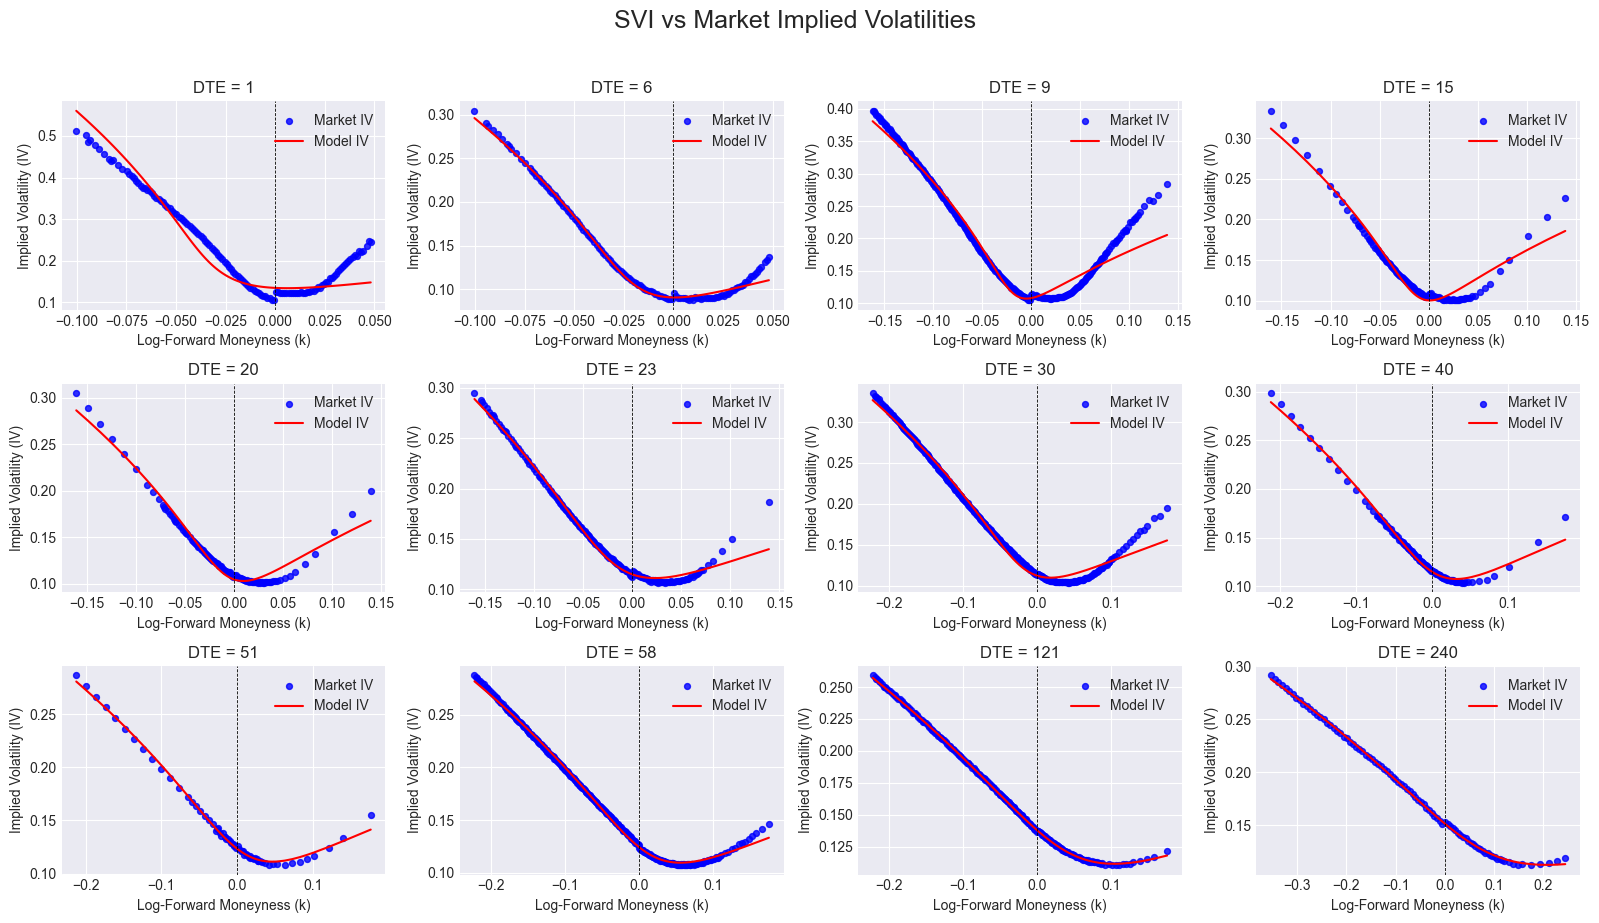

In [124]:
svi.plot_smiles()

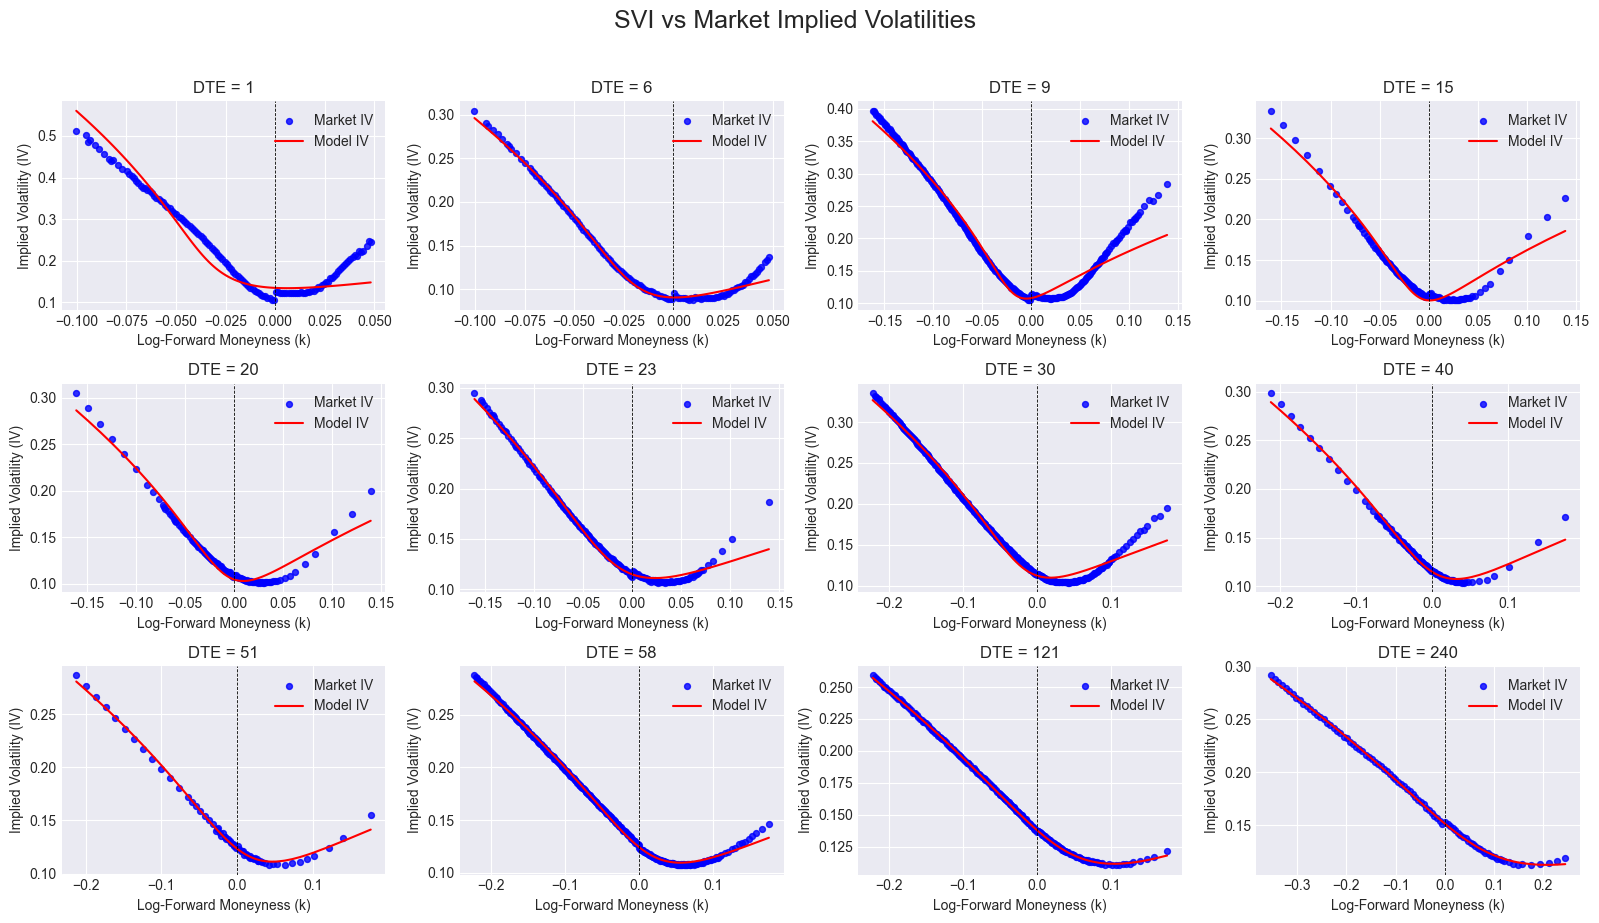

In [ ]:
svi.plot_smiles()

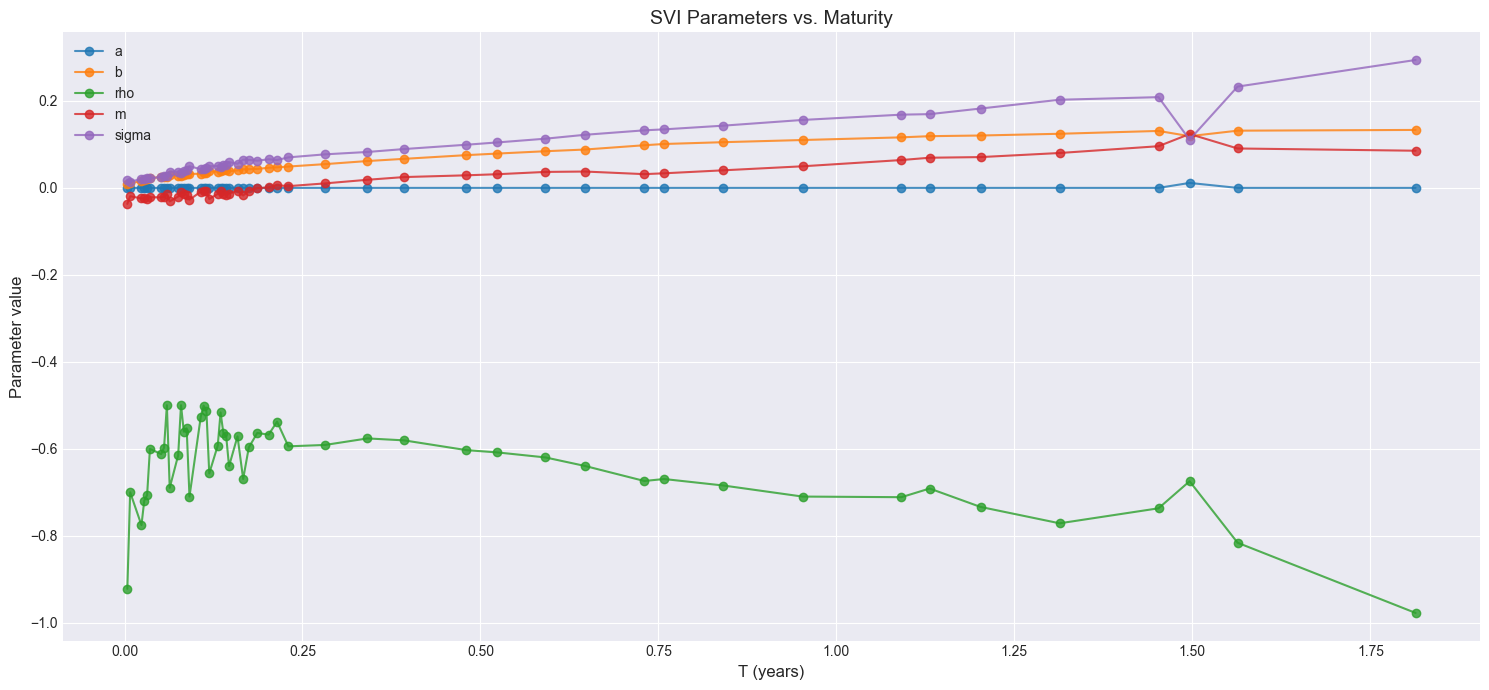

In [ ]:
svi.plot_params()
plt.show()

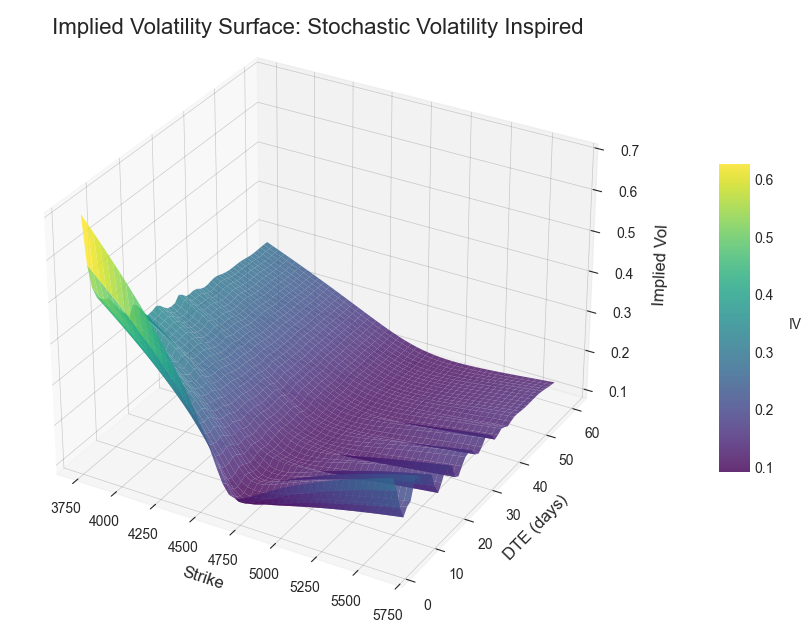

In [13]:
ax = svi.plot_surface(
    method_name="Stochastic Volatility Inspired",
    dte_band=(2 ,60)
)
plt.show()

In [95]:
arb_svi = svi.check_arbitrage()
arb_svi

,type,T,k,value
0,calendar,0.005952,-3.206607,-0.148677
1,calendar,0.005952,-3.186964,-0.147236
2,calendar,0.005952,-3.167320,-0.145795
3,calendar,0.005952,-3.147677,-0.144354
4,calendar,0.005952,-3.128034,-0.142913
...,...,...,...,...
5706,calendar,1.805889,0.152382,-0.238495
5707,calendar,1.805889,0.172025,-0.191743
5708,calendar,1.805889,0.191668,-0.142192
5709,calendar,1.805889,0.211311,-0.090170


In [96]:
print(f"Unique arbitrage type: {arb_svi["type"].unique()[0]}")

Unique arbitrage type: calendar


Despite fitting individual smiles very well, the interpolated raw SVI violates calendar arbitrage. Several remedies can be applied such as applying large penalization for slice corssign in the cost function or tilting the a paraemetr by the differenc between the 2 ivs but at the expense of a perfect fit of the smiles. In the next section we provide an extension of the SVi that aims to fit the entire surface in an arbitrgae-free manner.

## **Parametric Extensions: Surface Stochastic Volatility Inspired (SSVI) model**

In [97]:
class SSVI(IVSurfaceModel):
    """
    SSVI (Surface SVI) fit:  w(k,T) = θ(T)/2 · Φ(k,θ; ρ,η,γ)
      Φ = 1 + ρ φ k + sqrt((φ k + ρ)^2 + 1 - ρ²)
      φ(θ) = η θ^{-γ}
    Guarantees static-and-calendar-arbitrage if
      0<γ<1  and  0<η ≤ 2/(1+|ρ|).
    """
    def __init__(self,
                 maturity_band : Tuple = (1/252, 2),
                 moneyness_band: Tuple = (0.75, 1.25),
                 min_pts: int   = 6):
        super().__init__()
        self.maturity_band  = maturity_band
        self.moneyness_band = moneyness_band
        self.min_pts        = min_pts
        # will be filled by .fit()
        self.theta_interp   = None
        self.rho            = None
        self.eta            = None
        self.gamma          = None

    # ---------- SSVI kernel ---------------------------------------------
    @staticmethod
    def _phi(theta, eta, gamma):
        return eta * theta**(-gamma)

    @classmethod
    def _w_ssvi(cls, k, theta, rho, eta, gamma):
        φ = cls._phi(theta, eta, gamma)
        return 0.5*theta*(1 + rho*φ*k + np.sqrt((φ*k + rho)**2 + 1 - rho**2))

    # ---------- calibration ---------------------------------------------
    def fit(self, market_data: pd.DataFrame) -> None:
        self._spot = market_data["underlying_last"].iloc[0]
        df = self.prepare_iv_surface(market_data)

        # band filters ----------------------------------------------------
        min_T,max_T = self.maturity_band
        df = df[df["T"].between(min_T, max_T)]
        m_lo,m_hi   = self.moneyness_band
        k_lo,k_hi   = np.log(m_lo), np.log(m_hi)
        df = df[(df["k"].between(k_lo, k_hi))]
        self._last_market = df

        if df.empty:
            raise RuntimeError("No quotes after filters")

        # group by T to build θ(T) ---------------------------------------
        groups = df.groupby("T")
        T_grid = np.array(sorted(groups.size().index))
        θ_obs  = np.array([g["w"].min() for _,g in groups])   # crude θ guess
        θ_obs  = np.maximum.accumulate(θ_obs)                 # monotone
        self.theta_interp = PchipInterpolator(T_grid, θ_obs, extrapolate=True)

        k_all = df["k"].values
        T_all = df["T"].values
        w_all = df["w"].values
        θ_all = self.theta_interp(T_all)

        # --- objective: SSE over all quotes -----------------------------
        def sse(x):
            rho, eta, gamma = x
            #if not (0<eta<=2/(1+abs(rho))):
            #    return 1e10
            w_model = self._w_ssvi(k_all, θ_all, rho, eta, gamma)
            return np.sum((w_model - w_all)**2)

        # initial guess
        x0 = np.array([ -0.4,  0.5,  0.5])   # rho, eta, gamma
        bounds = [(-0.999,0.999),  # ρ
                  (1e-3, 2.0),     # η  (will be clipped below)
                  (1e-3, 0.999)]   # γ

        sol = differential_evolution(
                sse, bounds=bounds,
                strategy='best1bin', popsize=25, maxiter=300,
                tol=1e-7, polish=False  # we'll polish ourselves
            )
        if not sol.success:
            raise RuntimeError(sol.message)

        self.rho, self.eta, self.gamma = sol.x
        # clip η to the no-arb condition exactly
        self.eta = min(self.eta, 2/(1+abs(self.rho)))

        # store for plotting
        self._last_market = df.copy()

    # ---------- total variance query ------------------------------------
    def _implied_total_variance(self,
                                k: np.ndarray,
                                T: np.ndarray
                            ) -> np.ndarray:
        """
        Return w(k,T) with shape (len(T), len(k)).
        """
        k_arr = np.atleast_1d(k).astype(float)
        T_arr = np.atleast_1d(T).astype(float)

        # θ(T) from the monotone PCHIP
        theta = self.theta_interp(T_arr)          # (nT,)

        # broadcast via meshgrid
        K, Θ = np.meshgrid(k_arr, theta, indexing="xy")  # both (nT,nK)

        rho, eta, gamma = self.rho, self.eta, self.gamma
        return self._w_ssvi(K, Θ, rho, eta, gamma)    

In [98]:
ssvi = SSVI()
ssvi.fit(options_red)

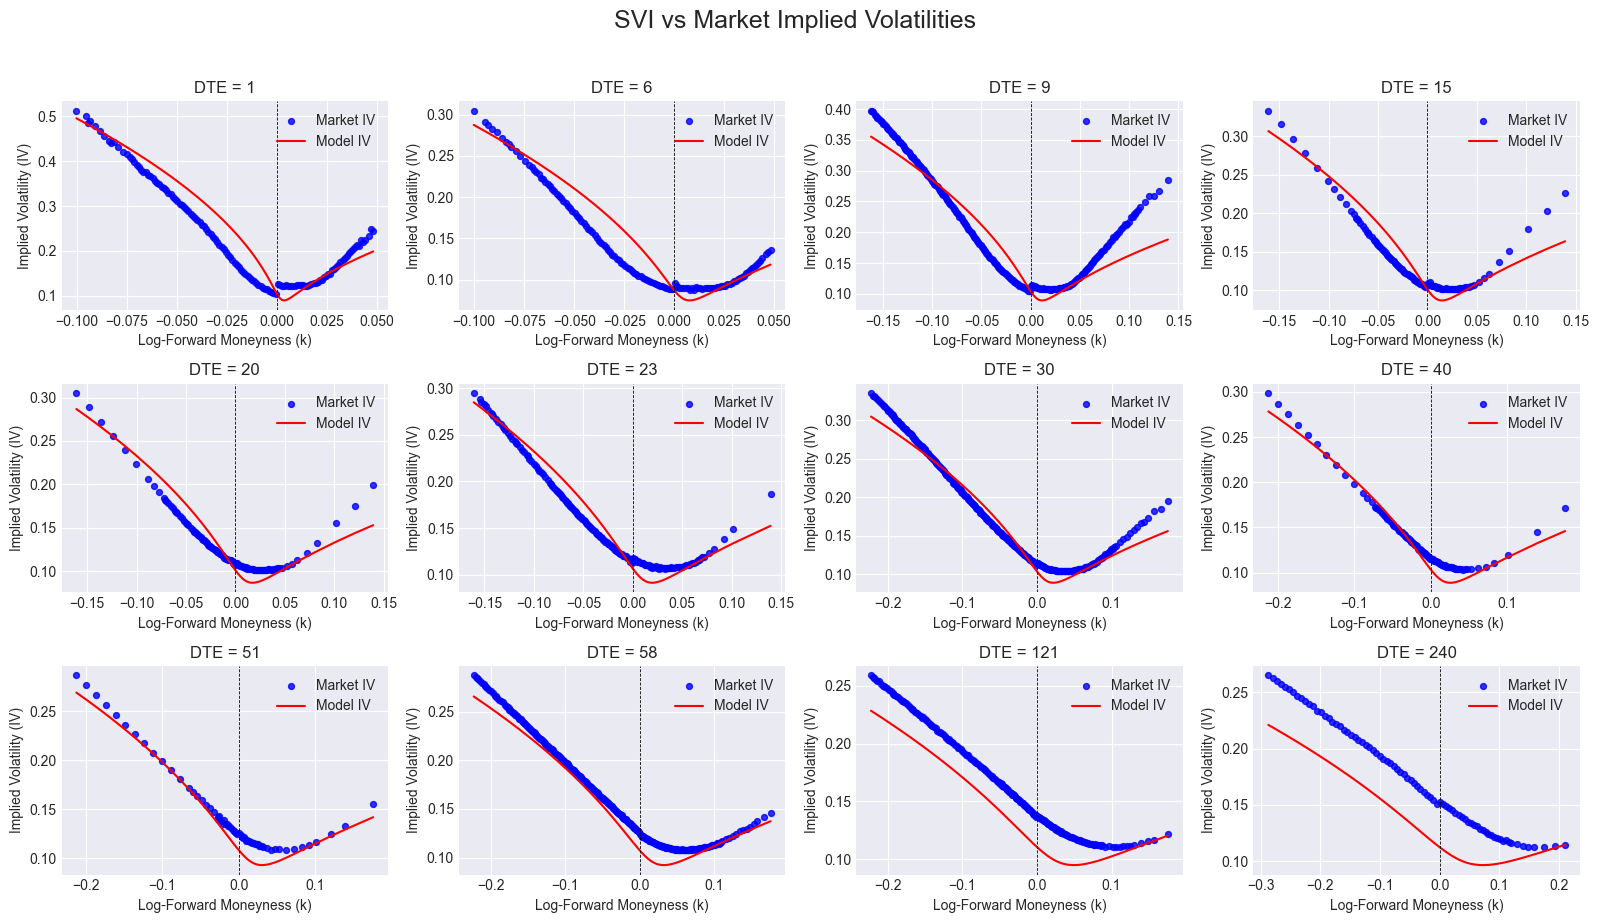

In [ ]:
ssvi.plot_smiles()

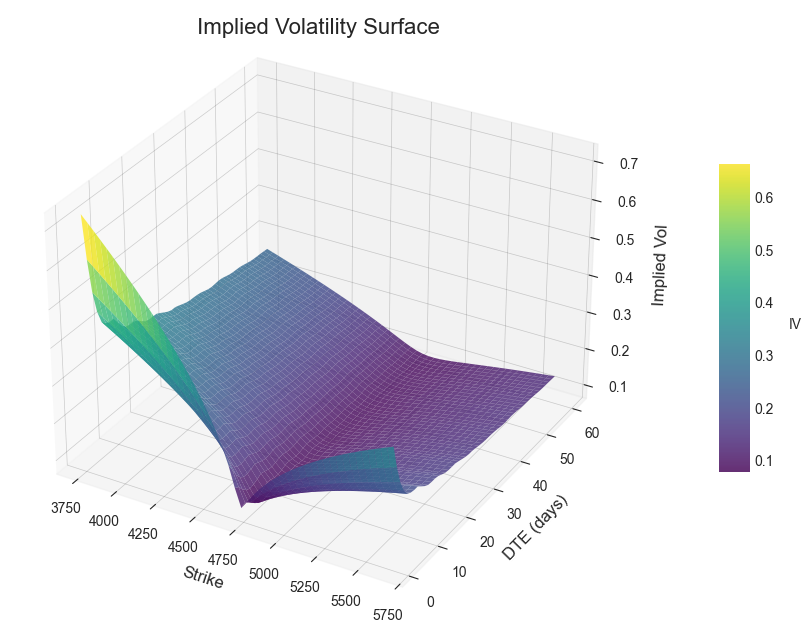

In [100]:
ssvi.plot_surface()
plt.show()

In [101]:
ssvi.check_arbitrage()

,type,T,k,value


Now the volatility is free of static and calendar arbitrage, but at the expsense of poor smiles fit because of the low dimensional parameterization (only 3 parameters) on the whole surface.